## Week 11 Homework (9)

### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it 
4. Describe how to use this to create arbitrary multivariate GLM regressions

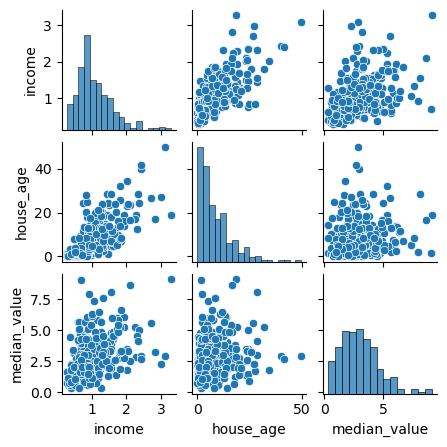

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

n = 300
# Simulate a Gaussian dependency structure
cov = np.array([
    [1.0, 0.8, 0.5],
    [0.8, 1.0, 0.3],
    [0.5, 0.3, 1.0]
])
z = stats.multivariate_normal(mean=[0,0,0], cov=cov).rvs(size=n)

# Marginals (simulate skewed distributions)
income = stats.lognorm(s=0.5).ppf(stats.norm().cdf(z[:,0]))
house_age = stats.expon(scale=10).ppf(stats.norm().cdf(z[:,1]))
median_value = stats.gamma(a=3).ppf(stats.norm().cdf(z[:,2]))

# Put into DataFrame
df = pd.DataFrame({
    'income': income,
    'house_age': house_age,
    'median_value': median_value
})

sns.pairplot(df, height=1.5)
plt.show()


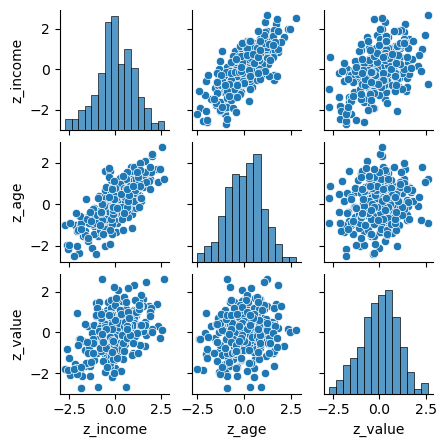

In [2]:
# Estimate marginal parameters via MLE
income_shape, income_loc, income_scale = stats.lognorm.fit(df['income'], floc=0)
age_loc, age_scale = stats.expon.fit(df['house_age'], floc=0)
value_a, value_loc, value_scale = stats.gamma.fit(df['median_value'], floc=0)

# Transform to uniform U(0,1) using fitted CDFs
u1 = stats.lognorm.cdf(df['income'], income_shape, loc=income_loc, scale=income_scale)
u2 = stats.expon.cdf(df['house_age'], loc=age_loc, scale=age_scale)
u3 = stats.gamma.cdf(df['median_value'], value_a, loc=value_loc, scale=value_scale)

# Transform to standard normal space via inverse CDF
z_income = stats.norm.ppf(u1)
z_age = stats.norm.ppf(u2)
z_value = stats.norm.ppf(u3)

# Stack for copula modeling
z_data = np.vstack([z_income, z_age, z_value]).T

sns.pairplot(pd.DataFrame(z_data, columns=['z_income','z_age','z_value']), height=1.5)
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [R]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: invalid value encountered in divide
  f = grid_counts / bin_width / len(x)
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:703: RuntimeWarning: divide by zero encountered in scalar divide
  bw /= bin_width


⚠️ Could not plot R_corr, falling back to 'L'. Reason: cannot convert float infinity to integer


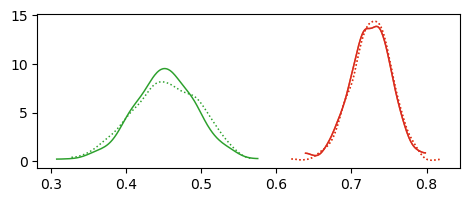

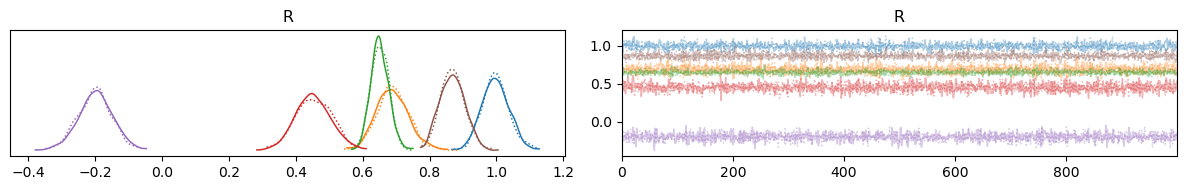

In [5]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

with pm.Model() as copula_model:
    L, corr, stds = pm.LKJCholeskyCov(
        'R', n=3, eta=2,
        sd_dist=pm.Exponential.dist(1.0, shape=3),
        compute_corr=True
    )

    obs = pm.MvNormal('obs', mu=np.zeros(3), chol=L, observed=z_data)
    copula_trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)

# Check if R_corr exists and contains valid, non-constant values
try:
    R_vals = copula_trace.posterior["R_corr"].values
    if np.isnan(R_vals).any() or np.isinf(R_vals).any() or np.all(R_vals == R_vals[0]):
        raise ValueError("R_corr has invalid or constant values")

    az.plot_trace(copula_trace, var_names=["R_corr"])
except Exception as e:
    print("⚠️ Could not plot R_corr, falling back to 'L'. Reason:", e)
    az.plot_trace(copula_trace, var_names=["R"])

plt.tight_layout()
plt.show()

In [6]:
# Mean correlation matrix from all posterior samples
mean_corr = copula_trace.posterior["R_corr"].mean(dim=["chain", "draw"]).values
print("Mean posterior correlation matrix:\n", np.round(mean_corr, 3))


Mean posterior correlation matrix:
 [[1.    0.726 0.452]
 [0.726 1.    0.192]
 [0.452 0.192 1.   ]]


/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: invalid value encountered in divide
  f = grid_counts / bin_width / len(x)
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:703: RuntimeWarning: divide by zero encountered in scalar divide
  bw /= bin_width


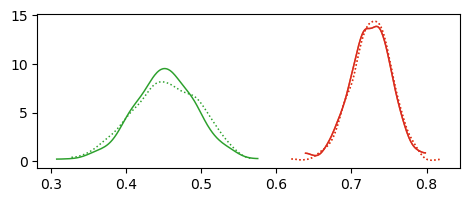

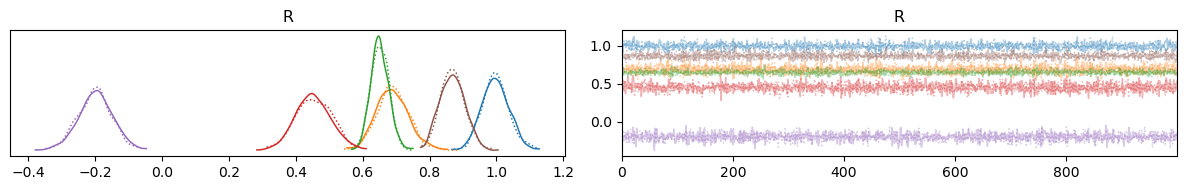

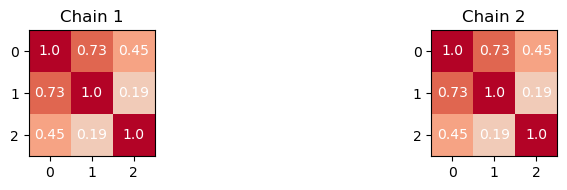

In [9]:
# Plot trace of correlation matrix (or fallback if needed)
try:
    az.plot_trace(copula_trace, var_names=['R_corr'])
except:
    az.plot_trace(copula_trace, var_names=['R'])
plt.tight_layout()

# Plot posterior mean correlation matrices per chain
fig, ax = plt.subplots(1, 2, figsize=(10, 2))  # two chains in this case

# Loop over chains and plot their mean R_corr matrices
mean_corrs = copula_trace.posterior['R_corr'].mean(dim='draw').values

for i, c in enumerate(mean_corrs):
    ax[i].imshow(c, vmin=-1, vmax=1, cmap='coolwarm')
    ax[i].set_title(f"Chain {i+1}")
    for k in range(c.shape[0]):
        for j in range(c.shape[1]):
            ax[i].text(j, k, s=str(round(c[k, j], 2)), 
                       color='white', ha='center', va='center')

plt.tight_layout()
plt.show()

A **copula** is a statistical tool that allows us to model the **dependence structure** between random variables separately from their individual marginal distributions. In the **first (direct) approach**, copulas are implemented by modeling all marginals and their joint correlation structure simultaneously within a single PyMC model, transforming observed data into a latent Gaussian space using inverse CDFs, and fitting a multivariate normal distribution on these transformed variables. In the **second (two-pass) approach**, each marginal distribution is fitted separately, then the data is transformed to standard normal space, and a Gaussian copula is estimated in a second step using only the transformed residuals. This modular design makes copulas particularly powerful for constructing **arbitrary multivariate GLMs**, where each response variable can follow a different distribution and regression structure, while the copula models the dependency between them — allowing complex, flexible multivariate modeling with interpretable marginal and joint behavior.

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop(columns=["income", "median_value"]).values
y = df[["income", "median_value"]].values

# Standardize
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

# Optionally subsample
X, y = X[:200], y[:200]  # limit for speed
n, p = X.shape
m = y.shape[1]

In [12]:
import pymc as pm
import arviz as az

with pm.Model() as spike_model:
    # Spike-and-slab variable selection for each output variable
    slab_sd = 10
    slab = pm.Normal('slab', mu=0, sigma=slab_sd, shape=(p, m))
    spike = pm.Bernoulli('spike', p=0.5, shape=(p, m))
    beta = pm.Deterministic('beta', slab * spike)

    sigma = pm.Exponential('sigma', 1.0, shape=m)
    
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    trace_spike = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [slab, sigma]
>BinaryGibbsMetropolis: [spike]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [13]:
with pm.Model() as diffuse_model:
    beta = pm.Normal('beta', mu=0, sigma=10, shape=(p, m))  # diffuse prior
    sigma = pm.Exponential('sigma', 1.0, shape=m)

    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    trace_diffuse = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


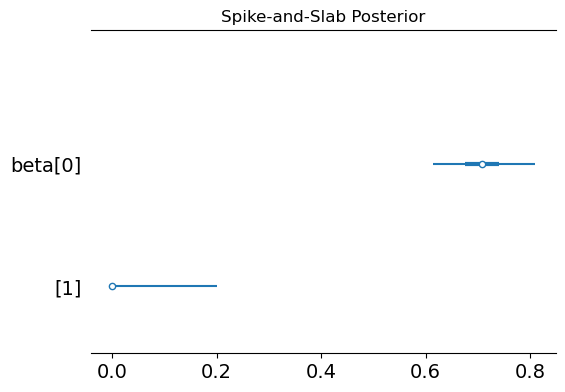

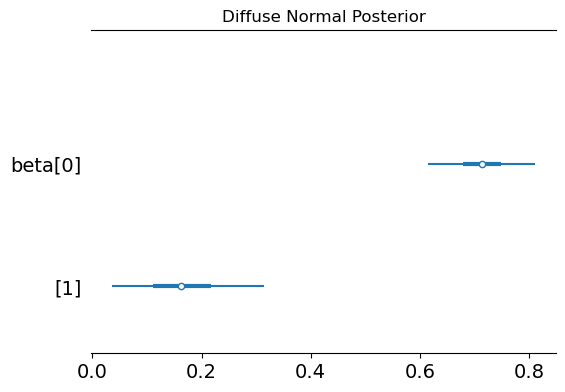

In [14]:
import matplotlib.pyplot as plt

# Plot selected vs all coefficients
az.plot_forest(trace_spike, var_names=["beta"], combined=True, legend=True)
plt.title("Spike-and-Slab Posterior")
plt.show()

az.plot_forest(trace_diffuse, var_names=["beta"], combined=True, legend=True)
plt.title("Diffuse Normal Posterior")
plt.show()


$n$ (observations): Increases the size of the likelihood and sampling cost linearly. Large $n$ slows down the evaluation of pm.Normal(...), especially with multivariate output.

$m$ (response variables): Multiplies the number of latent parameters and sigma terms. Increases model complexity.

$p$ (predictors): With diffuse priors, cost grows linearly with $p$. With spike-and-slab, cost grows quadratically or worse, since: Each $(p, m)$ pair has its own spike, slab, and interaction. Sampling discrete latent variables (Bernoulli spike) is slow and mixes poorly. Posterior may become multimodal.

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples


In [15]:
from sklearn.preprocessing import StandardScaler

# Assume df is already loaded
X = df.drop(columns=["income", "median_value"]).values
y = df[["income", "median_value"]].values

# Standardize
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

# Optionally subsample
X, y = X[:200], y[:200]
n, p = X.shape
m = y.shape[1]


In [16]:
with pm.Model() as horseshoe_model:
    # Global shrinkage
    tau = pm.HalfCauchy("tau", beta=1)

    # Local shrinkage for each beta_jk
    lam = pm.HalfCauchy("lam", beta=1, shape=(p, m))

    # Horseshoe prior on coefficients
    beta = pm.Normal("beta", mu=0, sigma=tau * lam, shape=(p, m))

    # Noise
    sigma = pm.Exponential("sigma", 1.0, shape=m)

    # Mean of multivariate regression
    mu = pm.math.dot(X, beta)
    
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    trace_horseshoe = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tau, lam, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [17]:
with pm.Model() as diffuse_model:
    beta = pm.Normal('beta', mu=0, sigma=10, shape=(p, m))
    sigma = pm.Exponential('sigma', 1.0, shape=m)

    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    trace_diffuse = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


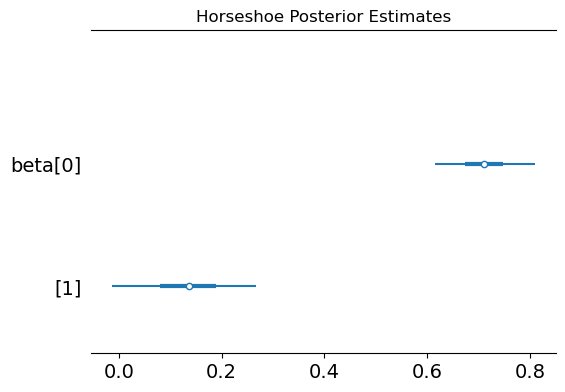

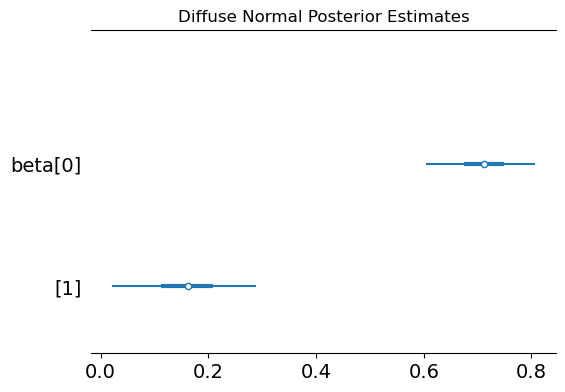

In [18]:
import matplotlib.pyplot as plt

# Horseshoe posterior
az.plot_forest(trace_horseshoe, var_names=['beta'], combined=True)
plt.title("Horseshoe Posterior Estimates")
plt.show()

# Diffuse prior posterior
az.plot_forest(trace_diffuse, var_names=['beta'], combined=True)
plt.title("Diffuse Normal Posterior Estimates")
plt.show()


We used the Horseshoe prior to regularize multivariate regression coefficients. The Horseshoe is a continuous analog of spike-and-slab, placing heavy mass near zero while allowing some large coefficients to escape. This enables variable selection through shrinkage.

As with spike-and-slab, increasing the number of observations ($n$) increases sampling cost linearly. Increasing the number of outcome variables ($m$) increases model complexity proportionally — the number of regression coefficients becomes $p \times m$. Importantly, increasing $p$ (predictors) has a nontrivial impact on runtime because each $\beta_{jk}$ has its own local shrinkage $\lambda_{jk}$ term, which slows sampling. However, compared to spike-and-slab, the Horseshoe is fully continuous and mixes faster, making it a more computationally efficient choice for larger models.

